# NFL EDA: Data Exploration & Feature Analysis

This notebook explores NFL data, computes features, and analyzes correlations with game outcomes.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import os

# Add src to path
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

from src.data import nfl_fetcher
from src.features import rest_schedule, form_metrics, strength

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Load Historical NFL Data (2020-2025)
seasons = [2020, 2021, 2022, 2023, 2024, 2025]
all_schedules = []

print("Loading NFL schedule data...")
for season in seasons:
    try:
        schedule = nfl_fetcher.fetch_nfl_schedule(season)
        all_schedules.append(schedule)
        print(f"Loaded {season}: {len(schedule)} games")
    except Exception as e:
        print(f"Error loading {season}: {e}")

if all_schedules:
    schedule_df = pd.concat(all_schedules, ignore_index=True)
    print(f"\nTotal games loaded: {len(schedule_df)}")
    
    # Ensure we have game_date column
    if 'gameday' in schedule_df.columns:
        schedule_df['game_date'] = pd.to_datetime(schedule_df['gameday'])
    elif 'game_date' not in schedule_df.columns:
        # Try other common date column names
        date_col = None
        for col in ['date', 'game_time', 'start_time']:
            if col in schedule_df.columns:
                date_col = col
                break
        if date_col:
            schedule_df['game_date'] = pd.to_datetime(schedule_df[date_col])
        else:
            print("Warning: Could not find date column. Please check schedule columns.")
            print("Available columns:", schedule_df.columns.tolist())
    
    # Compute margin and home win
    if 'home_score' in schedule_df.columns and 'away_score' in schedule_df.columns:
        schedule_df['margin'] = schedule_df['home_score'] - schedule_df['away_score']
        schedule_df['home_win'] = (schedule_df['margin'] > 0).astype(int)
        print(f"\nGames with scores: {schedule_df['home_win'].notna().sum()}")
        print(f"Home win rate: {schedule_df['home_win'].mean():.3f}")
    else:
        print("Warning: Score columns not found. Available columns:", schedule_df.columns.tolist())
    
    # Display summary
    print("\nSchedule DataFrame Info:")
    print(schedule_df.head())
    print(f"\nDate range: {schedule_df['game_date'].min()} to {schedule_df['game_date'].max()}")
else:
    print("No schedule data loaded!")


Loading NFL schedule data...
Loaded 2020: 269 games
Loaded 2021: 285 games
Loaded 2022: 284 games
Loaded 2023: 285 games
Loaded 2024: 285 games
Loaded 2025: 272 games

Total games loaded: 1680

Games with scores: 1680
Home win rate: 0.504

Schedule DataFrame Info:
           game_id  season game_type  week     gameday   weekday gametime  \
0   2020_01_HOU_KC    2020       REG     1  2020-09-10  Thursday    20:20   
1  2020_01_SEA_ATL    2020       REG     1  2020-09-13    Sunday    13:00   
2  2020_01_CLE_BAL    2020       REG     1  2020-09-13    Sunday    13:00   
3  2020_01_NYJ_BUF    2020       REG     1  2020-09-13    Sunday    13:00   
4   2020_01_LV_CAR    2020       REG     1  2020-09-13    Sunday    13:00   

  away_team  away_score home_team  ...    away_qb_name       home_qb_name  \
0       HOU        20.0        KC  ...  Deshaun Watson    Patrick Mahomes   
1       SEA        38.0       ATL  ...  Russell Wilson          Matt Ryan   
2       CLE         6.0       BAL  ...  B

Computing rest and schedule features...
This may take a few minutes...

Rest features added:
  - rest_home: 1584 values
  - rest_away: 1584 values
  - b2b_home: 0 back-to-back games
  - b2b_away: 0 back-to-back games

Rest Days Distribution (Home Teams):
rest_home
4.0      99
5.0      11
6.0     152
7.0     966
8.0     132
9.0       9
10.0     88
11.0      9
13.0     23
14.0     85
Name: count, dtype: int64


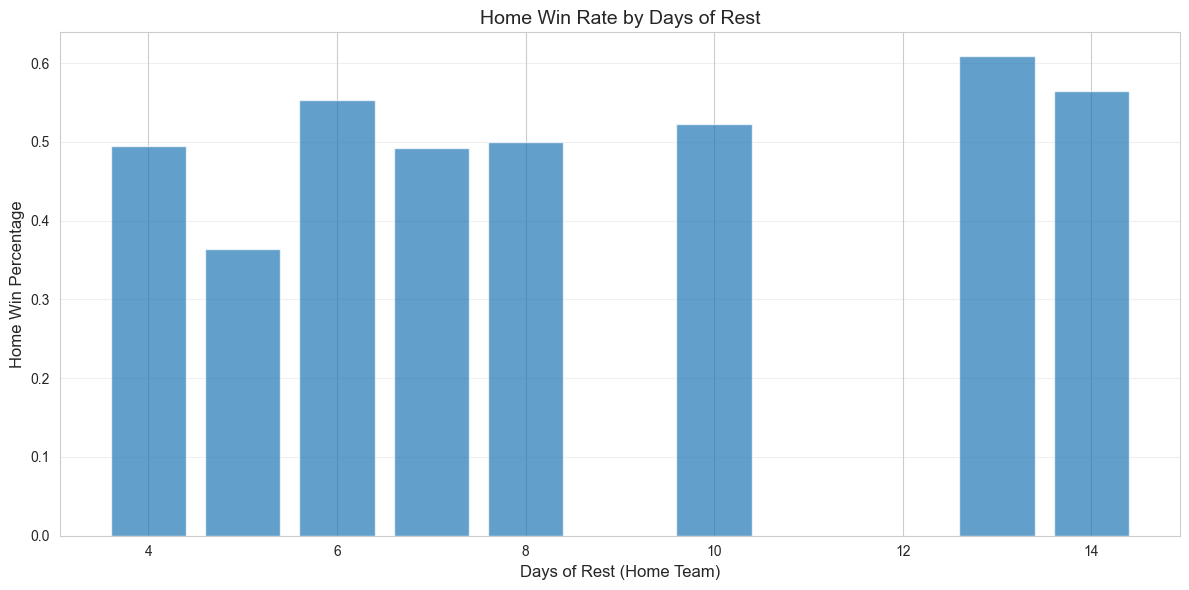


Win % by Rest Days (Home):
   rest_days   win_pct  games
0        4.0  0.494949     99
1        5.0  0.363636     11
2        6.0  0.552632    152
3        7.0  0.491718    966
4        8.0  0.500000    132
6       10.0  0.522727     88
8       13.0  0.608696     23
9       14.0  0.564706     85


In [3]:
# Apply Rest & Schedule Features
if 'schedule_df' in locals() and len(schedule_df) > 0:
    print("Computing rest and schedule features...")
    print("This may take a few minutes...")
    
    # Add rest features
    features_df = rest_schedule.add_rest_features(schedule_df, schedule_df)
    
    print("\nRest features added:")
    print(f"  - rest_home: {features_df['rest_home'].notna().sum()} values")
    print(f"  - rest_away: {features_df['rest_away'].notna().sum()} values")
    print(f"  - b2b_home: {features_df['b2b_home'].sum()} back-to-back games")
    print(f"  - b2b_away: {features_df['b2b_away'].sum()} back-to-back games")
    
    # Analyze rest day distributions
    if 'rest_home' in features_df.columns:
        print("\nRest Days Distribution (Home Teams):")
        rest_dist = features_df['rest_home'].value_counts().sort_index()
        print(rest_dist.head(10))
        
        # Visualize rest days impact
        if 'home_win' in features_df.columns:
            rest_analysis = features_df.groupby('rest_home')['home_win'].agg(['mean', 'count']).reset_index()
            rest_analysis.columns = ['rest_days', 'win_pct', 'games']
            rest_analysis = rest_analysis[rest_analysis['games'] >= 10]  # Filter to meaningful sample sizes
            
            plt.figure(figsize=(12, 6))
            plt.bar(rest_analysis['rest_days'], rest_analysis['win_pct'], alpha=0.7)
            plt.xlabel('Days of Rest (Home Team)', fontsize=12)
            plt.ylabel('Home Win Percentage', fontsize=12)
            plt.title('Home Win Rate by Days of Rest', fontsize=14)
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print("\nWin % by Rest Days (Home):")
            print(rest_analysis)
else:
    print("Schedule data not available. Run the previous cell first.")


In [4]:
# Apply Form Features (EPA) - Using nfl-data-py
if 'features_df' in locals():
    print("Loading play-by-play data for form metrics...")
    print("Note: This may take several minutes and requires significant memory.")
    
    try:
        import nfl_data_py as nfl
        pbp_data = []
        
        for season in seasons:
            try:
                print(f"Loading PBP for {season}...")
                pbp = nfl.import_pbp_data([season])
                if len(pbp) > 0:
                    pbp_data.append(pbp)
                    print(f"  Loaded {len(pbp)} plays for {season}")
                else:
                    print(f"  No data available for {season} (may be future season)")
            except Exception as e:
                print(f"  Could not load PBP for {season}: {e}")
        
        if pbp_data:
            pbp_df = pd.concat(pbp_data, ignore_index=True)
            
            # Ensure game_date column exists (nfl_data_py uses 'game_date')
            if 'game_date' in pbp_df.columns:
                pbp_df['game_date'] = pd.to_datetime(pbp_df['game_date'])
            elif 'gameday' in pbp_df.columns:
                pbp_df['game_date'] = pd.to_datetime(pbp_df['gameday'])
            else:
                print("Warning: Could not find date column in PBP data")
                print("Available columns:", pbp_df.columns.tolist()[:20])
                pbp_df = None
            
            if pbp_df is not None:
                print(f"\nTotal plays loaded: {len(pbp_df)}")
                print("Computing form features (this may take a while)...")
                
                # Add form features for different windows
                for window in [3, 5, 10]:
                    print(f"  Computing {window}-game rolling EPA...")
                    features_df = form_metrics.add_form_features_nfl(features_df, pbp_df, window=window)
                
                print("\nForm features added:")
                form_cols = [col for col in features_df.columns if col.startswith('form_')]
                for col in form_cols:
                    non_null = features_df[col].notna().sum()
                    print(f"  - {col}: {non_null} values")
        else:
            print("No play-by-play data loaded. Skipping form features.")
            
    except ImportError:
        print("nfl-data-py not available. Install with: pip install nfl-data-py")
        print("Skipping form features.")
    except Exception as e:
        print(f"Error loading play-by-play data: {e}")
        import traceback
        traceback.print_exc()
        print("Continuing without form features...")
else:
    print("Features DataFrame not available. Run previous cells first.")


Loading play-by-play data for form metrics...
Note: This may take several minutes and requires significant memory.
Loading PBP for 2020...
2020 done.
Downcasting floats.
  Loaded 47705 plays for 2020
Loading PBP for 2021...
2021 done.
Downcasting floats.
  Loaded 49922 plays for 2021
Loading PBP for 2022...
2022 done.
Downcasting floats.
  Loaded 49434 plays for 2022
Loading PBP for 2023...
2023 done.
Downcasting floats.
  Loaded 49665 plays for 2023
Loading PBP for 2024...
2024 done.
Downcasting floats.
  Loaded 49492 plays for 2024
Loading PBP for 2025...
  Could not load PBP for 2025: name 'Error' is not defined

Total plays loaded: 246218
Computing form features (this may take a while)...
  Computing 3-game rolling EPA...
  Computing 5-game rolling EPA...
  Computing 10-game rolling EPA...

Form features added:
  - form_home_epa_off_3: 1632 values
  - form_away_epa_off_3: 1632 values
  - form_home_epa_def_3: 1632 values
  - form_away_epa_def_3: 1632 values
  - form_home_epa_off_5: 

In [5]:
# Apply Opponent Strength Features
if 'features_df' in locals():
    print("Computing opponent strength features...")
    print("This may take a few minutes...")
    
    features_df = strength.add_opponent_strength_features(features_df, schedule_df, league='nfl')
    
    print("\nOpponent strength features added:")
    print(f"  - opp_strength_home_season: {features_df['opp_strength_home_season'].notna().sum()} values")
    print(f"  - opp_strength_away_season: {features_df['opp_strength_away_season'].notna().sum()} values")
    
    if 'opp_strength_home_season' in features_df.columns:
        print(f"\nOpponent Strength Stats:")
        print(f"  Home team avg: {features_df['opp_strength_home_season'].mean():.2f}")
        print(f"  Away team avg: {features_df['opp_strength_away_season'].mean():.2f}")
else:
    print("Features DataFrame not available. Run previous cells first.")


Computing opponent strength features...
This may take a few minutes...

Opponent strength features added:
  - opp_strength_home_season: 1584 values
  - opp_strength_away_season: 1584 values

Opponent Strength Stats:
  Home team avg: 0.07
  Away team avg: -0.05


In [6]:
# Add Team Strength Features (Season-to-Date Performance)
if 'features_df' in locals() and 'schedule_df' in locals():
    print("Computing team strength features...")
    
    # Calculate season-to-date win percentage and point differential for each team
    def compute_team_strength_features(games_df, historical_games):
        df = games_df.copy()
        
        # Initialize columns
        df['home_team_win_pct'] = np.nan
        df['away_team_win_pct'] = np.nan
        df['home_team_point_diff'] = np.nan
        df['away_team_point_diff'] = np.nan
        
        for idx, row in df.iterrows():
            game_date = pd.to_datetime(row['game_date'])
            home_team = row['home_team']
            away_team = row['away_team']
            season = row.get('season', game_date.year)
            
            # Get all games before this date in the same season
            season_games = historical_games[
                (pd.to_datetime(historical_games['game_date']) < game_date) &
                (historical_games.get('season', pd.to_datetime(historical_games['game_date']).dt.year) == season)
            ]
            
            # Home team stats
            home_games = season_games[
                (season_games['home_team'] == home_team) | (season_games['away_team'] == home_team)
            ]
            if len(home_games) > 0:
                home_wins = 0
                home_point_diff = []
                for _, game in home_games.iterrows():
                    if game['home_team'] == home_team:
                        if game.get('home_score', 0) > game.get('away_score', 0):
                            home_wins += 1
                        home_point_diff.append(game.get('home_score', 0) - game.get('away_score', 0))
                    else:
                        if game.get('away_score', 0) > game.get('home_score', 0):
                            home_wins += 1
                        home_point_diff.append(game.get('away_score', 0) - game.get('home_score', 0))
                
                df.loc[idx, 'home_team_win_pct'] = home_wins / len(home_games) if len(home_games) > 0 else 0.5
                df.loc[idx, 'home_team_point_diff'] = np.mean(home_point_diff) if home_point_diff else 0
            
            # Away team stats
            away_games = season_games[
                (season_games['home_team'] == away_team) | (season_games['away_team'] == away_team)
            ]
            if len(away_games) > 0:
                away_wins = 0
                away_point_diff = []
                for _, game in away_games.iterrows():
                    if game['home_team'] == away_team:
                        if game.get('home_score', 0) > game.get('away_score', 0):
                            away_wins += 1
                        away_point_diff.append(game.get('home_score', 0) - game.get('away_score', 0))
                    else:
                        if game.get('away_score', 0) > game.get('home_score', 0):
                            away_wins += 1
                        away_point_diff.append(game.get('away_score', 0) - game.get('home_score', 0))
                
                df.loc[idx, 'away_team_win_pct'] = away_wins / len(away_games) if len(away_games) > 0 else 0.5
                df.loc[idx, 'away_team_point_diff'] = np.mean(away_point_diff) if away_point_diff else 0
        
        return df
    
    features_df = compute_team_strength_features(features_df, schedule_df)
    
    print("\nTeam strength features added:")
    print(f"  - home_team_win_pct: {features_df['home_team_win_pct'].notna().sum()} values")
    print(f"  - away_team_win_pct: {features_df['away_team_win_pct'].notna().sum()} values")
    print(f"  - home_team_point_diff: {features_df['home_team_point_diff'].notna().sum()} values")
    print(f"  - away_team_point_diff: {features_df['away_team_point_diff'].notna().sum()} values")
    
    if 'home_team_win_pct' in features_df.columns:
        print(f"\nTeam Strength Stats:")
        print(f"  Home team avg win %: {features_df['home_team_win_pct'].mean():.3f}")
        print(f"  Away team avg win %: {features_df['away_team_win_pct'].mean():.3f}")
else:
    print("Features DataFrame or schedule_df not available.")


Computing team strength features...

Team strength features added:
  - home_team_win_pct: 1584 values
  - away_team_win_pct: 1584 values
  - home_team_point_diff: 1493 values
  - away_team_point_diff: 1491 values

Team Strength Stats:
  Home team avg win %: 0.500
  Away team avg win %: 0.499


In [7]:
# Add Interaction and Derived Features
if 'features_df' in locals():
    print("Adding interaction and derived features...")
    
    # Rest differential
    if 'rest_home' in features_df.columns and 'rest_away' in features_df.columns:
        features_df['rest_differential'] = features_df['rest_home'] - features_df['rest_away']
        features_df['rest_advantage_home'] = (features_df['rest_home'] > features_df['rest_away']).astype(int)
        print("  - Added rest_differential and rest_advantage_home")
    
    # Team strength differentials
    if 'home_team_win_pct' in features_df.columns and 'away_team_win_pct' in features_df.columns:
        features_df['win_pct_differential'] = features_df['home_team_win_pct'] - features_df['away_team_win_pct']
        print("  - Added win_pct_differential")
    
    if 'home_team_point_diff' in features_df.columns and 'away_team_point_diff' in features_df.columns:
        features_df['point_diff_differential'] = features_df['home_team_point_diff'] - features_df['away_team_point_diff']
        print("  - Added point_diff_differential")
    
    # Opponent strength differential
    if 'opp_strength_home_season' in features_df.columns and 'opp_strength_away_season' in features_df.columns:
        features_df['opp_strength_differential'] = features_df['opp_strength_home_season'] - features_df['opp_strength_away_season']
        print("  - Added opp_strength_differential")
    
    # Week and time features
    if 'game_date' in features_df.columns:
        features_df['week_number'] = pd.to_datetime(features_df['game_date']).dt.isocalendar().week
        features_df['month'] = pd.to_datetime(features_df['game_date']).dt.month
        features_df['is_playoff'] = features_df.get('game_type', '').str.contains('POST', case=False, na=False).astype(int)
        print("  - Added week_number, month, is_playoff")
    
    # Form differentials (if form features exist)
    form_cols = [col for col in features_df.columns if col.startswith('form_')]
    if form_cols:
        # Find matching home/away pairs
        for window in [3, 5, 10]:
            home_off = f'form_home_epa_off_{window}'
            away_off = f'form_away_epa_off_{window}'
            if home_off in features_df.columns and away_off in features_df.columns:
                features_df[f'form_epa_off_diff_{window}'] = features_df[home_off] - features_df[away_off]
                print(f"  - Added form_epa_off_diff_{window}")
            
            home_def = f'form_home_epa_def_{window}'
            away_def = f'form_away_epa_def_{window}'
            if home_def in features_df.columns and away_def in features_df.columns:
                features_df[f'form_epa_def_diff_{window}'] = features_df[home_def] - features_df[away_def]
                print(f"  - Added form_epa_def_diff_{window}")
    
    print("\nInteraction features added successfully!")
else:
    print("Features DataFrame not available.")


Adding interaction and derived features...
  - Added rest_differential and rest_advantage_home
  - Added win_pct_differential
  - Added point_diff_differential
  - Added opp_strength_differential
  - Added week_number, month, is_playoff
  - Added form_epa_off_diff_3
  - Added form_epa_def_diff_3
  - Added form_epa_off_diff_5
  - Added form_epa_def_diff_5
  - Added form_epa_off_diff_10
  - Added form_epa_def_diff_10

Interaction features added successfully!


Analyzing 48 features...


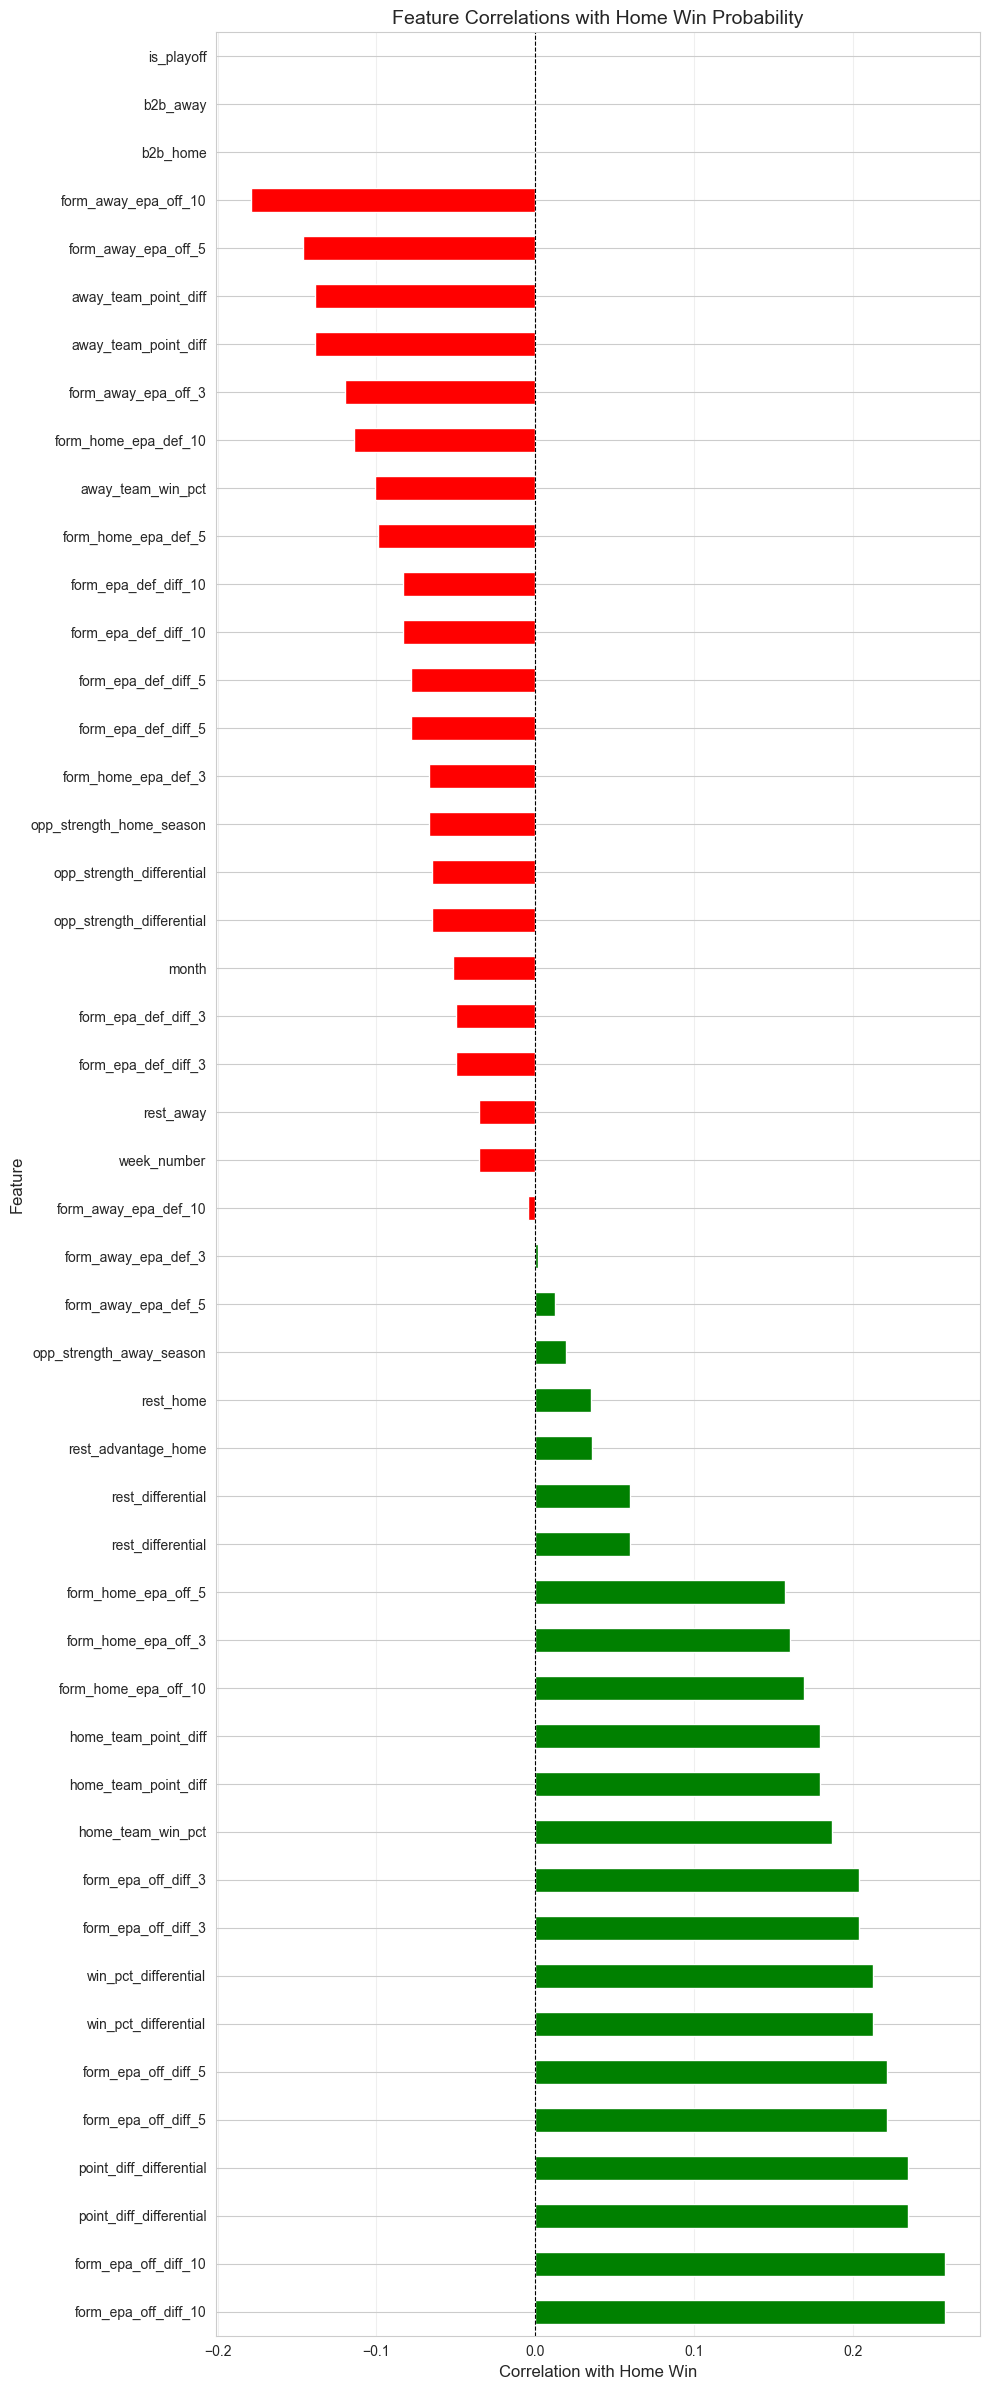


Top Features Affecting Home Win (by correlation):
 1. form_epa_off_diff_10                 0.2584
 2. form_epa_off_diff_10                 0.2584
 3. point_diff_differential              0.2347
 4. point_diff_differential              0.2347
 5. form_epa_off_diff_5                  0.2218
 6. form_epa_off_diff_5                  0.2218
 7. win_pct_differential                 0.2127
 8. win_pct_differential                 0.2127
 9. form_epa_off_diff_3                  0.2042
10. form_epa_off_diff_3                  0.2042

Bottom Features (negative correlation):
 1. form_away_epa_off_5                 -0.1465
 2. form_away_epa_off_10                -0.1790
 3. b2b_home                                nan
 4. b2b_away                                nan
 5. is_playoff                              nan


In [8]:
# Correlation Analysis with Home Win
if 'features_df' in locals() and 'home_win' in features_df.columns:
    # Collect all feature columns
    feature_cols = [
        'rest_home', 'rest_away', 'b2b_home', 'b2b_away',
        'opp_strength_home_season', 'opp_strength_away_season',
        'home_team_win_pct', 'away_team_win_pct',
        'home_team_point_diff', 'away_team_point_diff',
        'rest_differential', 'rest_advantage_home',
        'win_pct_differential', 'point_diff_differential',
        'opp_strength_differential', 'week_number', 'month', 'is_playoff'
    ]
    
    # Add form features if they exist
    form_cols = [col for col in features_df.columns if col.startswith('form_')]
    feature_cols.extend(form_cols)
    
    # Add interaction features
    interaction_cols = [col for col in features_df.columns if 'diff' in col.lower() or 'differential' in col.lower()]
    feature_cols.extend(interaction_cols)
    
    # Filter to columns that exist and have data
    available_cols = [col for col in feature_cols if col in features_df.columns]
    available_cols = [col for col in available_cols if features_df[col].notna().sum() > 100]
    
    if available_cols:
        print(f"Analyzing {len(available_cols)} features...")
        
        # Compute correlations
        corr_data = features_df[available_cols + ['home_win']].corr()['home_win'].drop('home_win')
        corr_data = corr_data.sort_values(ascending=False)
        
        # Create visualization
        plt.figure(figsize=(10, max(8, len(available_cols) * 0.5)))
        corr_data.plot(kind='barh', color=['green' if x > 0 else 'red' for x in corr_data.values])
        plt.xlabel('Correlation with Home Win', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title('Feature Correlations with Home Win Probability', fontsize=14)
        plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\nTop Features Affecting Home Win (by correlation):")
        print("=" * 60)
        for idx, (feature, corr) in enumerate(corr_data.head(10).items(), 1):
            print(f"{idx:2d}. {feature:35s} {corr:7.4f}")
        
        print("\nBottom Features (negative correlation):")
        print("=" * 60)
        for idx, (feature, corr) in enumerate(corr_data.tail(5).items(), 1):
            print(f"{idx:2d}. {feature:35s} {corr:7.4f}")
    else:
        print("No feature columns available for correlation analysis.")
else:
    print("Features DataFrame or home_win column not available.")


Data points available: 1346
Features: 36

Training set: 1076 samples
Test set: 270 samples

Training Random Forest classifier...
Training LightGBM classifier...

Random Forest Performance:
  Accuracy: 0.6296

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.61      0.58      0.59       125
    Home Win       0.65      0.68      0.66       145

    accuracy                           0.63       270
   macro avg       0.63      0.63      0.63       270
weighted avg       0.63      0.63      0.63       270


LightGBM Performance:
  Accuracy: 0.5926

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.56      0.55      0.56       125
    Home Win       0.62      0.63      0.62       145

    accuracy                           0.59       270
   macro avg       0.59      0.59      0.59       270
weighted avg       0.59      0.59      0.59       270



<Figure size 1000x1800 with 0 Axes>

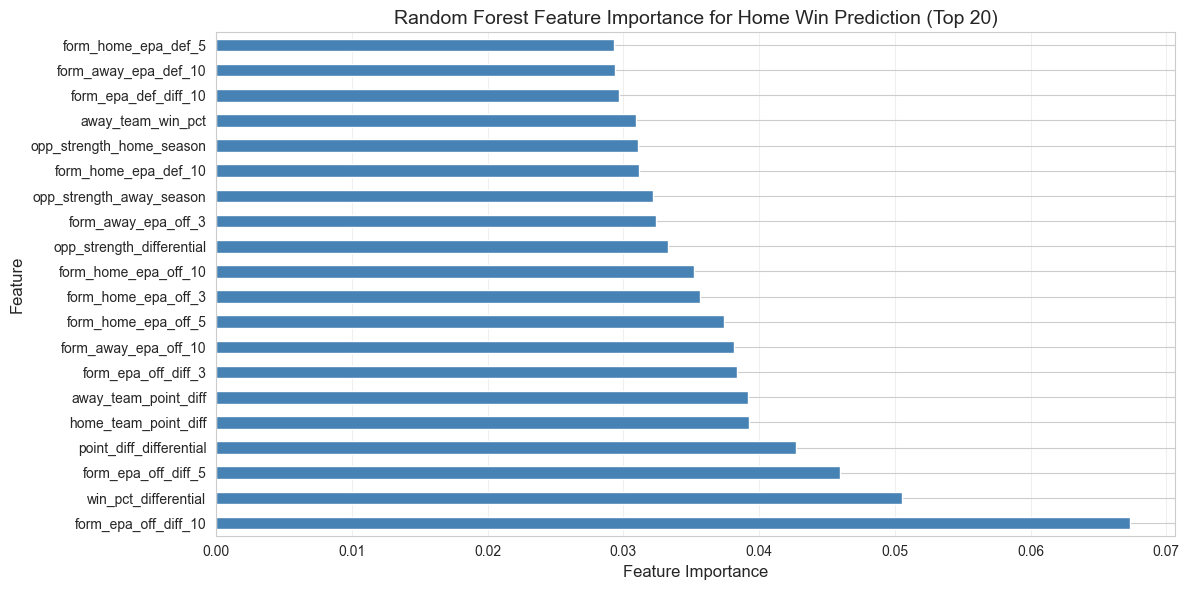


Feature Importance Rankings (Random Forest):
35. form_epa_off_diff_10                      0.0673
13. win_pct_differential                      0.0506
33. form_epa_off_diff_5                       0.0460
14. point_diff_differential                   0.0427
 9. home_team_point_diff                      0.0392
10. away_team_point_diff                      0.0392
31. form_epa_off_diff_3                       0.0384
28. form_away_epa_off_10                      0.0382
23. form_home_epa_off_5                       0.0374
19. form_home_epa_off_3                       0.0356
27. form_home_epa_off_10                      0.0352
15. opp_strength_differential                 0.0333
20. form_away_epa_off_3                       0.0324
 6. opp_strength_away_season                  0.0322
29. form_home_epa_def_10                      0.0312
 5. opp_strength_home_season                  0.0311
 8. away_team_win_pct                         0.0310
36. form_epa_def_diff_10                      0.0297


In [9]:
# Feature Importance via Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier

if 'features_df' in locals() and 'home_win' in features_df.columns:
    # Collect feature columns
    feature_cols = [
        'rest_home', 'rest_away', 'b2b_home', 'b2b_away',
        'opp_strength_home_season', 'opp_strength_away_season',
        'home_team_win_pct', 'away_team_win_pct',
        'home_team_point_diff', 'away_team_point_diff',
        'rest_differential', 'rest_advantage_home',
        'win_pct_differential', 'point_diff_differential',
        'opp_strength_differential', 'week_number', 'month', 'is_playoff'
    ]
    
    # Add form features if they exist
    form_cols = [col for col in features_df.columns if col.startswith('form_')]
    feature_cols.extend(form_cols)
    
    # Add interaction features
    interaction_cols = [col for col in features_df.columns if 'diff' in col.lower() or 'differential' in col.lower()]
    feature_cols.extend(interaction_cols)
    
    # Filter to available columns AND remove duplicates
    available_cols = [col for col in feature_cols if col in features_df.columns]
    # Remove duplicates while preserving order
    seen = set()
    available_cols = [col for col in available_cols if not (col in seen or seen.add(col))]
    
    # Prepare data (drop NaN rows)
    model_df = features_df[available_cols + ['home_win']].dropna()
    
    print(f"Data points available: {len(model_df)}")
    print(f"Features: {len(available_cols)}")
    
    if len(model_df) > 100:
        X = model_df[available_cols]
        y = model_df['home_win']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"\nTraining set: {len(X_train)} samples")
        print(f"Test set: {len(X_test)} samples")
        
        # Train Random Forest
        print("\nTraining Random Forest classifier...")
        rf = RandomForestClassifier(
            n_estimators=200, 
            max_depth=12, 
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        
        # Also train LightGBM (often better for tabular data)
        print("Training LightGBM classifier...")
        try:
            lgbm = LGBMClassifier(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=7,
                num_leaves=31,
                random_state=42,
                verbose=-1
            )
            lgbm.fit(X_train, y_train)
            use_lgbm = True
        except Exception as e:
            print(f"LightGBM failed: {e}")
            print("Using Random Forest only")
            use_lgbm = False
        
        # Predictions
        y_pred_rf = rf.predict(X_test)
        y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
        
        if use_lgbm:
            y_pred_lgbm = lgbm.predict(X_test)
            y_pred_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]
        
        # Metrics
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        print(f"\nRandom Forest Performance:")
        print(f"  Accuracy: {accuracy_rf:.4f}")
        print(f"\nClassification Report:")
        print(classification_report(y_test, y_pred_rf, target_names=['Away Win', 'Home Win']))
        
        if use_lgbm:
            accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
            print(f"\nLightGBM Performance:")
            print(f"  Accuracy: {accuracy_lgbm:.4f}")
            print(f"\nClassification Report:")
            print(classification_report(y_test, y_pred_lgbm, target_names=['Away Win', 'Home Win']))
        
        # Feature importance (use best model)
        if use_lgbm and accuracy_lgbm > accuracy_rf:
            best_model = lgbm
            best_name = "LightGBM"
            importance_values = lgbm.feature_importances_
        else:
            best_model = rf
            best_name = "Random Forest"
            importance_values = rf.feature_importances_
        
        # Ensure available_cols and importance_values have same length
        # (should be fine after removing duplicates, but double-check)
        assert len(available_cols) == len(importance_values), \
            f"Mismatch: {len(available_cols)} features but {len(importance_values)} importance values"
        
        importance_df = pd.DataFrame({
            'feature': available_cols,
            'importance': importance_values
        }).sort_values('importance', ascending=False)
        
        # Visualize feature importance
        plt.figure(figsize=(10, max(8, len(available_cols) * 0.5)))
        importance_df.head(20).plot(x='feature', y='importance', kind='barh', legend=False, color='steelblue')
        plt.xlabel('Feature Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title(f'{best_name} Feature Importance for Home Win Prediction (Top 20)', fontsize=14)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"\nFeature Importance Rankings ({best_name}):")
        print("=" * 60)
        for idx, row in importance_df.head(20).iterrows():
            print(f"{idx + 1:2d}. {row['feature']:40s} {row['importance']:7.4f}")
    else:
        print(f"Not enough data: {len(model_df)} rows (need >100)")
        print("Try loading more seasons or check data availability.")
else:
    print("Features DataFrame or home_win column not available.")

Back-to-Back Analysis:
   is_b2b   win_pct  games
0   False  0.504167   1680


C:\Users\DMB\AppData\Local\Temp\ipykernel_4440\2282090174.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  opp_strength_analysis = features_df.groupby('opp_strength_bin')['home_win'].agg(['mean', 'count']).reset_index()
C:\Users\DMB\AppData\Local\Temp\ipykernel_4440\2282090174.py:70: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  form_analysis = features_df.groupby('form_bin')['home_win'].agg(['mean', 'count']).reset_index()


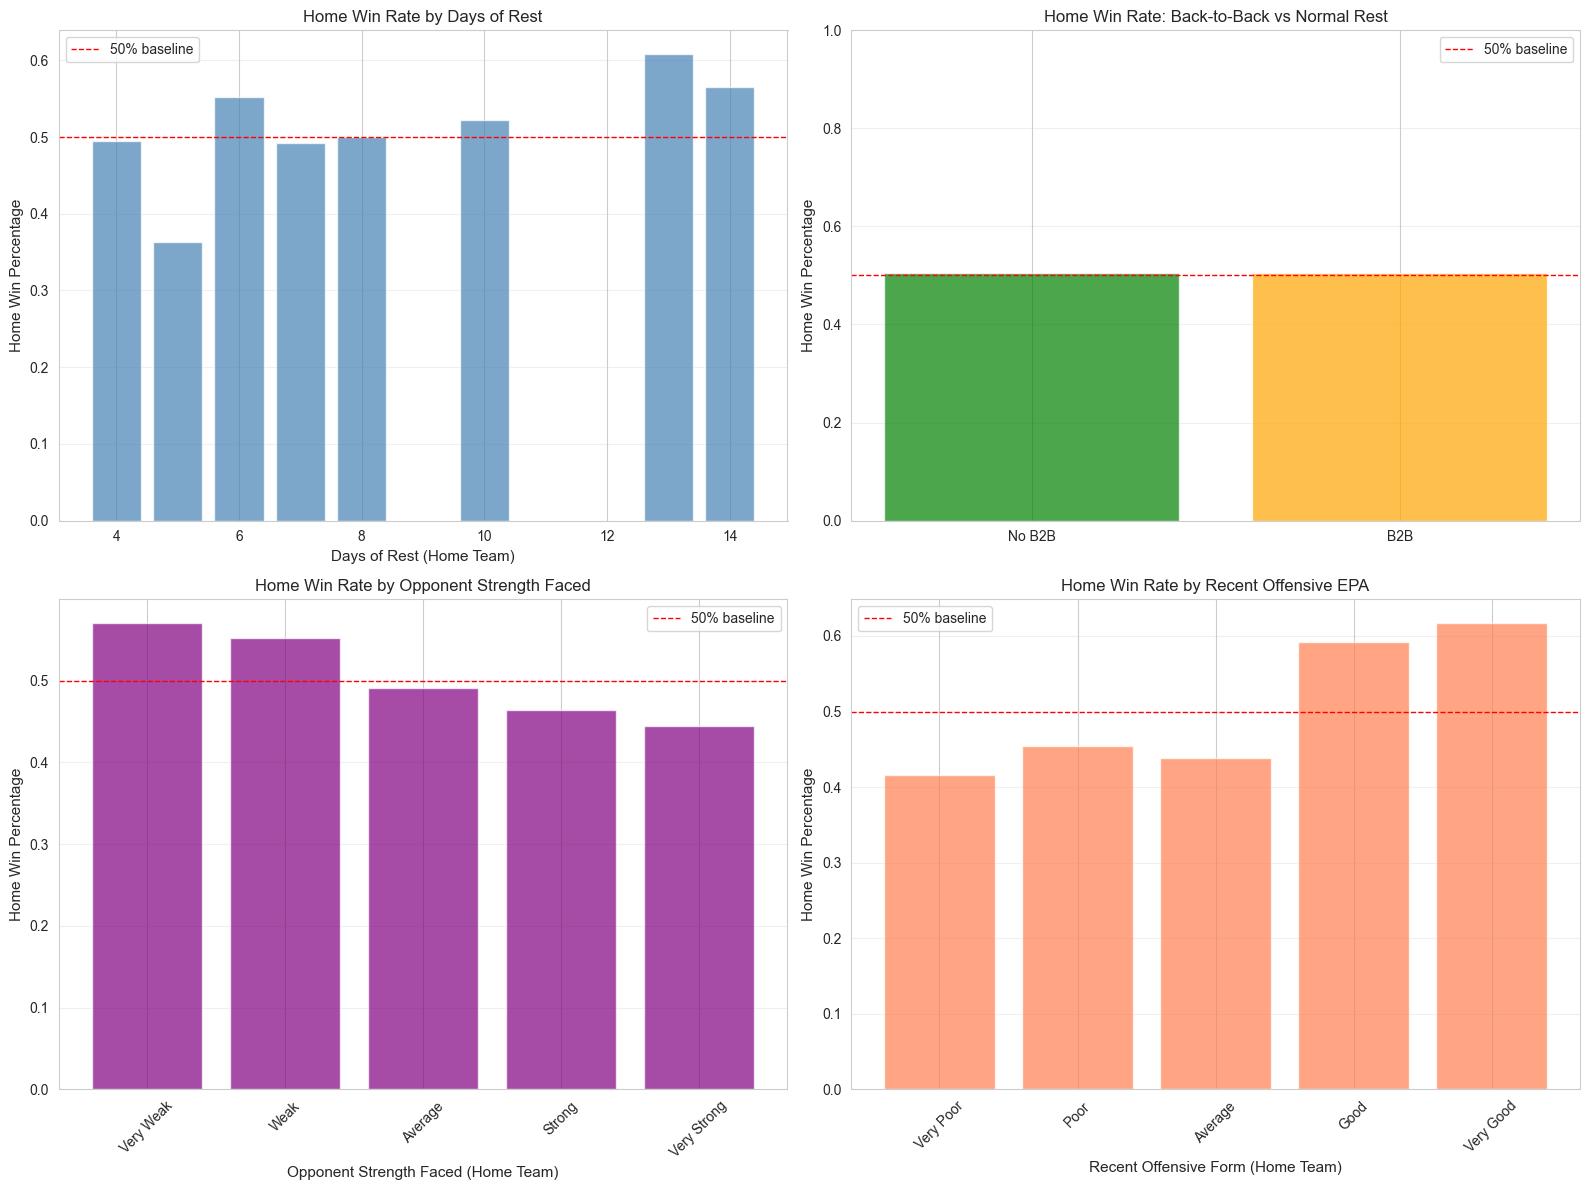


SITUATIONAL ANALYSIS SUMMARY

Average rest days (home): 7.5
Back-to-back frequency (home): 0.0%


In [10]:
# Situational Analysis: Deep Dive into Specific Factors
if 'features_df' in locals() and 'home_win' in features_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Rest Days Impact
    if 'rest_home' in features_df.columns:
        rest_analysis = features_df.groupby('rest_home')['home_win'].agg(['mean', 'count']).reset_index()
        rest_analysis.columns = ['rest_days', 'win_pct', 'games']
        rest_analysis = rest_analysis[rest_analysis['games'] >= 10]
        
        axes[0, 0].bar(rest_analysis['rest_days'], rest_analysis['win_pct'], alpha=0.7, color='steelblue')
        axes[0, 0].axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='50% baseline')
        axes[0, 0].set_xlabel('Days of Rest (Home Team)', fontsize=11)
        axes[0, 0].set_ylabel('Home Win Percentage', fontsize=11)
        axes[0, 0].set_title('Home Win Rate by Days of Rest', fontsize=12)
        axes[0, 0].grid(axis='y', alpha=0.3)
        axes[0, 0].legend()
    
    # 2. Back-to-Back Impact
    if 'b2b_home' in features_df.columns:
        b2b_analysis = features_df.groupby('b2b_home')['home_win'].agg(['mean', 'count']).reset_index()
        b2b_analysis.columns = ['is_b2b', 'win_pct', 'games']
        
        axes[0, 1].bar(['No B2B', 'B2B'], b2b_analysis['win_pct'], alpha=0.7, color=['green', 'orange'])
        axes[0, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='50% baseline')
        axes[0, 1].set_ylabel('Home Win Percentage', fontsize=11)
        axes[0, 1].set_title('Home Win Rate: Back-to-Back vs Normal Rest', fontsize=12)
        axes[0, 1].grid(axis='y', alpha=0.3)
        axes[0, 1].legend()
        axes[0, 1].set_ylim([0, 1])
        
        print("Back-to-Back Analysis:")
        print(b2b_analysis)
    
    # 3. Opponent Strength Impact
    if 'opp_strength_home_season' in features_df.columns:
        # Create bins for opponent strength
        features_df['opp_strength_bin'] = pd.qcut(
            features_df['opp_strength_home_season'], 
            q=5, 
            labels=['Very Weak', 'Weak', 'Average', 'Strong', 'Very Strong'],
            duplicates='drop'
        )
        opp_strength_analysis = features_df.groupby('opp_strength_bin')['home_win'].agg(['mean', 'count']).reset_index()
        opp_strength_analysis.columns = ['opp_strength', 'win_pct', 'games']
        
        axes[1, 0].bar(opp_strength_analysis['opp_strength'], opp_strength_analysis['win_pct'], 
                      alpha=0.7, color='purple')
        axes[1, 0].axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='50% baseline')
        axes[1, 0].set_xlabel('Opponent Strength Faced (Home Team)', fontsize=11)
        axes[1, 0].set_ylabel('Home Win Percentage', fontsize=11)
        axes[1, 0].set_title('Home Win Rate by Opponent Strength Faced', fontsize=12)
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(axis='y', alpha=0.3)
        axes[1, 0].legend()
    
    # 4. Form Impact (if available)
    form_cols = [col for col in features_df.columns if col.startswith('form_home_epa_off_')]
    if form_cols:
        # Use 3-game window if available
        form_col = 'form_home_epa_off_3' if 'form_home_epa_off_3' in form_cols else form_cols[0]
        if features_df[form_col].notna().sum() > 50:
            # Create bins for form
            features_df['form_bin'] = pd.qcut(
                features_df[form_col], 
                q=5, 
                labels=['Very Poor', 'Poor', 'Average', 'Good', 'Very Good'],
                duplicates='drop'
            )
            form_analysis = features_df.groupby('form_bin')['home_win'].agg(['mean', 'count']).reset_index()
            form_analysis.columns = ['form_level', 'win_pct', 'games']
            
            axes[1, 1].bar(form_analysis['form_level'], form_analysis['win_pct'], 
                          alpha=0.7, color='coral')
            axes[1, 1].axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='50% baseline')
            axes[1, 1].set_xlabel('Recent Offensive Form (Home Team)', fontsize=11)
            axes[1, 1].set_ylabel('Home Win Percentage', fontsize=11)
            axes[1, 1].set_title('Home Win Rate by Recent Offensive EPA', fontsize=12)
            axes[1, 1].tick_params(axis='x', rotation=45)
            axes[1, 1].grid(axis='y', alpha=0.3)
            axes[1, 1].legend()
        else:
            axes[1, 1].text(0.5, 0.5, 'Insufficient form data', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Form Impact (Data Not Available)', fontsize=12)
    else:
        axes[1, 1].text(0.5, 0.5, 'Form features not computed\n(Run PBP cell to enable)', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Form Impact (Not Available)', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "=" * 60)
    print("SITUATIONAL ANALYSIS SUMMARY")
    print("=" * 60)
    
    if 'rest_home' in features_df.columns:
        avg_rest = features_df['rest_home'].mean()
        print(f"\nAverage rest days (home): {avg_rest:.1f}")
    
    if 'b2b_home' in features_df.columns:
        b2b_pct = features_df['b2b_home'].mean() * 100
        print(f"Back-to-back frequency (home): {b2b_pct:.1f}%")
else:
    print("Features DataFrame not available.")


In [11]:
# Check for 2025 Season Data and Future Games
if 'schedule_df' in locals():
    print("Checking for 2025 season data...")
    
    # Check what seasons we have
    available_seasons = sorted(schedule_df.get('season', pd.to_datetime(schedule_df['game_date']).dt.year).unique())
    print(f"Available seasons: {available_seasons}")
    
    # Check for 2025 games
    if 2025 in available_seasons:
        games_2025 = schedule_df[schedule_df.get('season', pd.to_datetime(schedule_df['game_date']).dt.year) == 2025]
        print(f"\n2025 season games found: {len(games_2025)}")
        
        # Check which games have scores (completed) vs no scores (future)
        if 'home_score' in games_2025.columns and 'away_score' in games_2025.columns:
            completed_2025 = games_2025[games_2025['home_score'].notna() & games_2025['away_score'].notna()]
            future_2025 = games_2025[games_2025['home_score'].isna() | games_2025['away_score'].isna()]
            
            print(f"  Completed games: {len(completed_2025)}")
            print(f"  Future games (no scores): {len(future_2025)}")
            
            if len(future_2025) > 0:
                print(f"\nUpcoming games in 2025:")
                print(future_2025[['game_date', 'away_team', 'home_team', 'week']].head(10))
        else:
            print("  Score columns not found - cannot determine completed vs future games")
    else:
        print("\nNo 2025 season data found in schedule")
    
    # Check for any future games (games after today)
    today = pd.Timestamp.now()
    future_games = schedule_df[pd.to_datetime(schedule_df['game_date']) > today]
    if len(future_games) > 0:
        print(f"\nTotal future games (all seasons): {len(future_games)}")
        print(f"Date range: {future_games['game_date'].min()} to {future_games['game_date'].max()}")
    else:
        print("\nNo future games found")
else:
    print("Schedule DataFrame not available.")


Checking for 2025 season data...
Available seasons: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

2025 season games found: 272
  Completed games: 164
  Future games (no scores): 108

Upcoming games in 2025:
      game_date away_team home_team  week
1572 2025-11-20       BUF       HOU    12
1573 2025-11-23       NYJ       BAL    12
1574 2025-11-23       PIT       CHI    12
1575 2025-11-23        NE       CIN    12
1576 2025-11-23       NYG       DET    12
1577 2025-11-23       MIN        GB    12
1578 2025-11-23       IND        KC    12
1579 2025-11-23       SEA       TEN    12
1580 2025-11-23       JAX       ARI    12
1581 2025-11-23       CLE        LV    12

Total future games (all seasons): 108
Date range: 2025-11-20 00:00:00 to 2026-01-04 00:00:00


PREDICTING WIN PROBABILITIES FOR FUTURE GAMES

Found 108 future games to predict

Computing features for future games...

Available features for future games: 18 out of 36
Missing features (likely form/EPA features): ['form_away_epa_def_3', 'form_epa_off_diff_10', 'form_epa_def_diff_10', 'form_home_epa_off_3', 'form_home_epa_def_3', 'form_epa_def_diff_5', 'form_epa_def_diff_3', 'form_epa_off_diff_5', 'form_away_epa_off_3', 'form_away_epa_off_5']...

Games with sufficient features for prediction: 108

Using LightGBM model for predictions

PREDICTIONS FOR UPCOMING GAMES

Showing next 20 games:
 game_date away_team @ home_team  home_win_probability predicted_winner  confidence
2025-11-20       BUF @       HOU              0.203269              BUF    0.593462
2025-11-23        TB @        LA              0.835167               LA    0.670333
2025-11-23       PHI @       DAL              0.662132              DAL    0.324264
2025-11-23       CLE @        LV              0.495999           

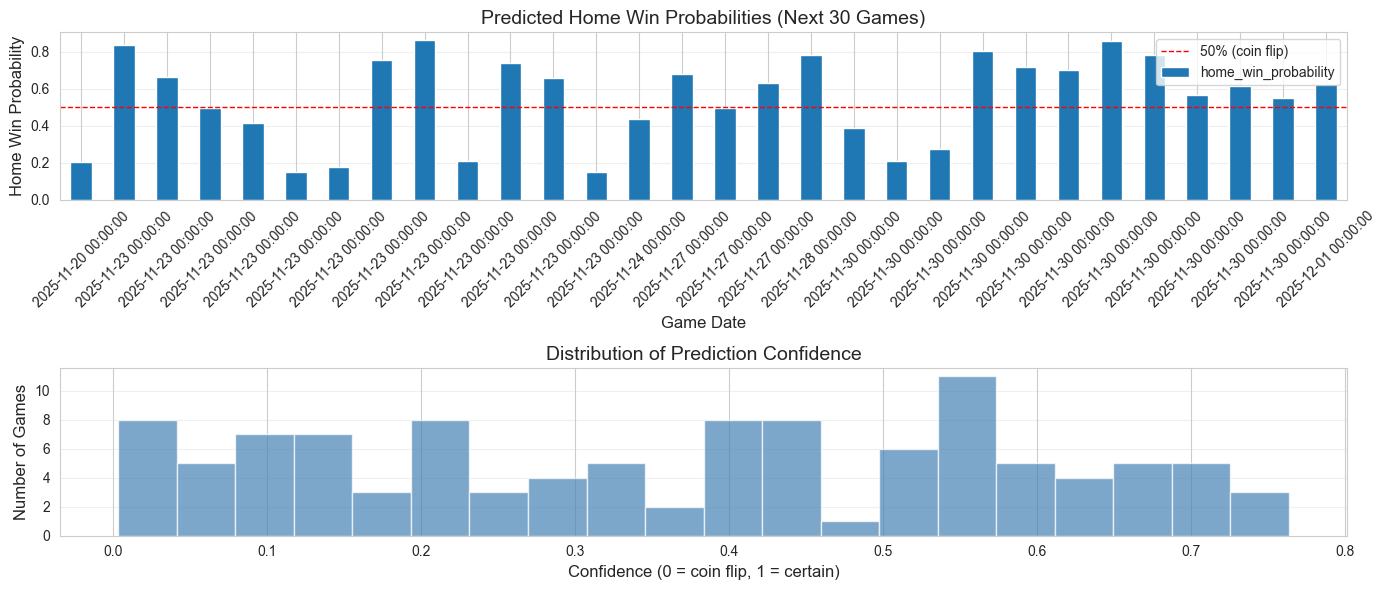

In [12]:
# Predict Win Probabilities for Future Games
if 'features_df' in locals() and ('rf' in locals() or 'lgbm' in locals()):
    print("=" * 70)
    print("PREDICTING WIN PROBABILITIES FOR FUTURE GAMES")
    print("=" * 70)
    
    # Get future games (no scores)
    today = pd.Timestamp.now()
    future_games = schedule_df[
        (pd.to_datetime(schedule_df['game_date']) > today) |
        (schedule_df.get('home_score', pd.Series([np.nan] * len(schedule_df))).isna())
    ].copy()
    
    if len(future_games) > 0:
        print(f"\nFound {len(future_games)} future games to predict")
        
        # Compute features for future games using historical data
        print("\nComputing features for future games...")
        
        # Start with rest features
        future_features = rest_schedule.add_rest_features(future_games, schedule_df)
        
        # Add opponent strength features
        future_features = strength.add_opponent_strength_features(future_features, schedule_df, league='nfl')
        
        # Add team strength features (reuse function from earlier)
        if 'compute_team_strength_features' in globals():
            future_features = compute_team_strength_features(future_features, schedule_df)
        else:
            # Define it inline if not available
            def compute_team_strength_features(games_df, historical_games):
                df = games_df.copy()
                df['home_team_win_pct'] = np.nan
                df['away_team_win_pct'] = np.nan
                df['home_team_point_diff'] = np.nan
                df['away_team_point_diff'] = np.nan
                
                for idx, row in df.iterrows():
                    game_date = pd.to_datetime(row['game_date'])
                    home_team = row['home_team']
                    away_team = row['away_team']
                    season = row.get('season', game_date.year)
                    
                    season_games = historical_games[
                        (pd.to_datetime(historical_games['game_date']) < game_date) &
                        (historical_games.get('season', pd.to_datetime(historical_games['game_date']).dt.year) == season)
                    ]
                    
                    # Home team stats
                    home_games = season_games[(season_games['home_team'] == home_team) | (season_games['away_team'] == home_team)]
                    if len(home_games) > 0:
                        home_wins = sum(1 for _, g in home_games.iterrows() 
                                      if (g['home_team'] == home_team and g.get('home_score', 0) > g.get('away_score', 0)) or
                                         (g['away_team'] == home_team and g.get('away_score', 0) > g.get('home_score', 0)))
                        home_point_diff = [g.get('home_score', 0) - g.get('away_score', 0) if g['home_team'] == home_team 
                                         else g.get('away_score', 0) - g.get('home_score', 0) for _, g in home_games.iterrows()]
                        df.loc[idx, 'home_team_win_pct'] = home_wins / len(home_games)
                        df.loc[idx, 'home_team_point_diff'] = np.mean(home_point_diff) if home_point_diff else 0
                    
                    # Away team stats
                    away_games = season_games[(season_games['home_team'] == away_team) | (season_games['away_team'] == away_team)]
                    if len(away_games) > 0:
                        away_wins = sum(1 for _, g in away_games.iterrows() 
                                      if (g['home_team'] == away_team and g.get('home_score', 0) > g.get('away_score', 0)) or
                                         (g['away_team'] == away_team and g.get('away_score', 0) > g.get('home_score', 0)))
                        away_point_diff = [g.get('home_score', 0) - g.get('away_score', 0) if g['home_team'] == away_team 
                                          else g.get('away_score', 0) - g.get('home_score', 0) for _, g in away_games.iterrows()]
                        df.loc[idx, 'away_team_win_pct'] = away_wins / len(away_games)
                        df.loc[idx, 'away_team_point_diff'] = np.mean(away_point_diff) if away_point_diff else 0
                return df
            
            future_features = compute_team_strength_features(future_features, schedule_df)
        
        # Add interaction features
        if 'rest_home' in future_features.columns:
            future_features['rest_differential'] = future_features['rest_home'] - future_features['rest_away']
            future_features['rest_advantage_home'] = (future_features['rest_home'] > future_features['rest_away']).astype(int)
        if 'home_team_win_pct' in future_features.columns:
            future_features['win_pct_differential'] = future_features['home_team_win_pct'] - future_features['away_team_win_pct']
        if 'home_team_point_diff' in future_features.columns:
            future_features['point_diff_differential'] = future_features['home_team_point_diff'] - future_features['away_team_point_diff']
        if 'opp_strength_home_season' in future_features.columns:
            future_features['opp_strength_differential'] = future_features['opp_strength_home_season'] - future_features['opp_strength_away_season']
        if 'game_date' in future_features.columns:
            future_features['week_number'] = pd.to_datetime(future_features['game_date']).dt.isocalendar().week
            future_features['month'] = pd.to_datetime(future_features['game_date']).dt.month
            future_features['is_playoff'] = future_features.get('game_type', '').str.contains('POST', case=False, na=False).astype(int)
        
        # CRITICAL FIX: Filter available_cols to only columns that exist in future_features
        # Form features won't exist for future games (no PBP data yet)
        available_cols_for_future = [col for col in available_cols if col in future_features.columns]
        
        print(f"\nAvailable features for future games: {len(available_cols_for_future)} out of {len(available_cols)}")
        if len(available_cols_for_future) < len(available_cols):
            missing = set(available_cols) - set(available_cols_for_future)
            print(f"Missing features (likely form/EPA features): {list(missing)[:10]}...")
        
        # Filter to games that have enough features (using only available columns)
        future_predictable = future_features[
            future_features[available_cols_for_future].notna().sum(axis=1) >= len(available_cols_for_future) * 0.5
        ]
        
        if len(future_predictable) > 0:
            print(f"\nGames with sufficient features for prediction: {len(future_predictable)}")
            
            # Prepare features (fill missing with median from training data if available)
            X_future = future_predictable[available_cols_for_future].copy()
            
            # Fill missing values with median from training set if available
            if 'X_train' in locals():
                for col in available_cols_for_future:
                    if X_future[col].isna().any():
                        if col in X_train.columns:
                            median_val = X_train[col].median()
                            X_future[col] = X_future[col].fillna(median_val)
                        else:
                            X_future[col] = X_future[col].fillna(0)
            else:
                X_future = X_future.fillna(0)
            
            # IMPORTANT: We need to ensure X_future has the same columns as X_train
            # Add missing columns (form features) with default values
            missing_cols = set(available_cols) - set(available_cols_for_future)
            for col in missing_cols:
                X_future[col] = 0  # Default value for missing form features
            
            # Reorder columns to match training data
            X_future = X_future[available_cols]
            
            # Predict probabilities
            if 'use_lgbm' in locals() and use_lgbm and 'lgbm' in locals():
                future_probs = lgbm.predict_proba(X_future)[:, 1]
                model_name = "LightGBM"
            else:
                future_probs = rf.predict_proba(X_future)[:, 1]
                model_name = "Random Forest"
                
            # Create prediction dataframe
            predictions_df = pd.DataFrame({
                'game_date': future_predictable['game_date'],
                'away_team': future_predictable['away_team'],
                'home_team': future_predictable['home_team'],
                'home_win_probability': future_probs,
                'away_win_probability': 1 - future_probs,
                'predicted_winner': future_predictable['home_team'].where(future_probs > 0.5, future_predictable['away_team']),
                'confidence': np.abs(future_probs - 0.5) * 2  # 0-1 scale
            }).sort_values('game_date')
            
            print(f"\nUsing {model_name} model for predictions")
            print("\n" + "=" * 70)
            print("PREDICTIONS FOR UPCOMING GAMES")
            print("=" * 70)
            print(f"\nShowing next 20 games:")
            display_cols = ['game_date', 'away_team', '@', 'home_team', 'home_win_probability', 'predicted_winner', 'confidence']
            predictions_display = predictions_df.head(20).copy()
            predictions_display['@'] = '@'
            print(predictions_display[['game_date', 'away_team', '@', 'home_team', 'home_win_probability', 'predicted_winner', 'confidence']].to_string(index=False))
            
            # Summary statistics
            print(f"\n\nPrediction Summary:")
            print(f"  Average home win probability: {predictions_df['home_win_probability'].mean():.3f}")
            print(f"  Games where home team favored: {(predictions_df['home_win_probability'] > 0.5).sum()}")
            print(f"  Games where away team favored: {(predictions_df['home_win_probability'] < 0.5).sum()}")
            print(f"  Average confidence: {predictions_df['confidence'].mean():.3f}")
            
            # Visualize predictions
            plt.figure(figsize=(14, 8))
            plt.subplot(2, 1, 1)
            predictions_df.head(30).plot(x='game_date', y='home_win_probability', 
                                        kind='bar', figsize=(14, 6), ax=plt.gca())
            plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1, label='50% (coin flip)')
            plt.ylabel('Home Win Probability', fontsize=12)
            plt.xlabel('Game Date', fontsize=12)
            plt.title('Predicted Home Win Probabilities (Next 30 Games)', fontsize=14)
            plt.legend()
            plt.xticks(rotation=45)
            plt.grid(axis='y', alpha=0.3)
            
            plt.subplot(2, 1, 2)
            predictions_df['confidence'].hist(bins=20, alpha=0.7, color='steelblue')
            plt.xlabel('Confidence (0 = coin flip, 1 = certain)', fontsize=12)
            plt.ylabel('Number of Games', fontsize=12)
            plt.title('Distribution of Prediction Confidence', fontsize=14)
            plt.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
        else:
            print("\nNo future games have sufficient features for prediction.")
            print("This may be because:")
            print("  - Teams haven't played enough games yet this season")
            print("  - Some required features couldn't be computed")
    else:
        print("\nNo future games found to predict.")
else:
    print("Model or features not available. Run previous cells to train model first.")

In [13]:
# Export Models for Production Use
# This cell trains and saves models in the format expected by the production pipeline

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

from src.pipeline.train_models import train_and_save_models

if 'features_df' in locals() and 'home_win' in features_df.columns and 'margin' in features_df.columns:
    print("=" * 70)
    print("TRAINING AND EXPORTING MODELS FOR PRODUCTION")
    print("=" * 70)
    
    # Use the feature columns from the trained model
    if 'available_cols' in locals():
        feature_cols_to_use = available_cols
    else:
        # Fallback: collect feature columns
        feature_cols_to_use = [
            'rest_home', 'rest_away', 'b2b_home', 'b2b_away',
            'opp_strength_home_season', 'opp_strength_away_season',
            'home_team_win_pct', 'away_team_win_pct',
            'home_team_point_diff', 'away_team_point_diff',
            'rest_differential', 'rest_advantage_home',
            'win_pct_differential', 'point_diff_differential',
            'opp_strength_differential', 'week_number', 'month', 'is_playoff'
        ]
        form_cols = [col for col in features_df.columns if col.startswith('form_')]
        feature_cols_to_use.extend(form_cols)
        interaction_cols = [col for col in features_df.columns if 'diff' in col.lower() or 'differential' in col.lower()]
        feature_cols_to_use.extend(interaction_cols)
        # Remove duplicates
        seen = set()
        feature_cols_to_use = [col for col in feature_cols_to_use if not (col in seen or seen.add(col))]
        # Filter to columns that exist
        feature_cols_to_use = [col for col in feature_cols_to_use if col in features_df.columns]
    
    print(f"\nUsing {len(feature_cols_to_use)} features for model training")
    
    # Train and save models
    try:
        results = train_and_save_models(
            features_df,
            target_col='home_win',
            margin_col='margin',
            feature_cols=feature_cols_to_use,
            league='NFL',
            model_version='v1',
            use_lgbm=True,
            test_size=0.2,
            random_state=42
        )
        
        print("\n" + "=" * 70)
        print("MODEL EXPORT COMPLETE")
        print("=" * 70)
        print(f"\nModels saved:")
        print(f"  - Win Probability: {results['win_prob_model_path']}")
        print(f"  - Spread: {results['spread_model_path']}")
        print(f"  - Link Function: {results['link_function_path']}")
        print(f"  - Feature Medians: {results['feature_medians_path']}")
        
        print(f"\nModel Performance:")
        print(f"  Win Probability Accuracy: {results['accuracy']:.4f}")
        print(f"  Spread MAE: {results['mae']:.2f} points")
        print(f"  Spread RMSE: {results['rmse']:.2f} points")
        print(f"  Link Function: a={results['link_params'][0]:.4f}, b={results['link_params'][1]:.4f}")
        
        print(f"\nYou can now use these models in production with:")
        print(f"  python -m src.pipeline.refresh --league NFL --date YYYY-MM-DD --model-version v1")
        
    except Exception as e:
        print(f"\nError training models: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Features DataFrame with home_win and margin columns not available.")
    print("Run previous cells to prepare data.")


TRAINING AND EXPORTING MODELS FOR PRODUCTION

Using 36 features for model training
Training on 1257 samples, testing on 315 samples
Features: 36

Training spread model...
Spread Model (LGBM):
  MAE: 9.95 points
  RMSE: 12.24 points

Training win probability model...
Win Probability Model (LIGHTGBM_CALIBRATED):
  Accuracy: 0.5583
  Brier Score: 0.2342 (lower is better)

Calibrating link function...
Link function parameters: a=0.3000, b=0.3429

Model Consistency Check:
  Mean disagreement: 0.1900
  Sign agreement: 75.6%
  ⚠️  Warning: High disagreement between models. Consider ensemble approach.

Saved win probability model to d:\Code\sports-edge\notebooks\..\models\win_prob_model_nfl_v1.pkl
Saved spread model to d:\Code\sports-edge\notebooks\..\models\spread_model_nfl_v1.pkl
Saved link function to d:\Code\sports-edge\notebooks\..\models\link_function_nfl_v1.pkl
Saved feature medians to d:\Code\sports-edge\notebooks\..\models\feature_medians_nfl_v1.pkl

MODEL EXPORT COMPLETE

Models save

In [14]:
# Test Production Prediction Function
# Test the production predictor with a sample game

if 'features_df' in locals() and 'schedule_df' in locals():
    try:
        from src.models.predictor import GamePredictor, predict_single_game
        
        # Test with a recent game
        test_game = schedule_df.iloc[-10]  # Use a recent game
        
        print("Testing production predictor...")
        print(f"Game: {test_game['away_team']} @ {test_game['home_team']}")
        print(f"Date: {test_game['game_date']}")
        
        # Initialize predictor
        predictor = GamePredictor('NFL', 'v1')
        
        # Predict
        game_row = pd.DataFrame([test_game])
        prediction = predictor.predict(
            game_row,
            schedule_df,
            pbp_df if 'pbp_df' in locals() else None
        )
        
        print("\n" + "=" * 70)
        print("PRODUCTION PREDICTION TEST")
        print("=" * 70)
        print(f"\n{prediction['away_team']} @ {prediction['home_team']}")
        print(f"Predicted Spread: {prediction['predicted_spread']:.2f}")
        print(f"Home Win Probability: {prediction['home_win_probability']:.1%}")
        print(f"Away Win Probability: {prediction['away_win_probability']:.1%}")
        print(f"Predicted Winner: {prediction['predicted_winner']}")
        print(f"Confidence: {prediction['confidence']:.1%}")
        print(f"Interpretation: {prediction['spread_interpretation']}")
        
        # Compare to actual if available
        if 'home_score' in test_game and 'away_score' in test_game and pd.notna(test_game['home_score']):
            actual_margin = test_game['home_score'] - test_game['away_score']
            actual_winner = test_game['home_team'] if actual_margin > 0 else test_game['away_team']
            print(f"\nActual Result:")
            print(f"  Margin: {actual_margin:.1f}")
            print(f"  Winner: {actual_winner}")
            print(f"  Prediction Error: {abs(prediction['predicted_spread'] - actual_margin):.2f} points")
            print(f"  Correct Winner Prediction: {prediction['predicted_winner'] == actual_winner}")
        
        print("\n✓ Production predictor is working correctly!")
        
    except FileNotFoundError as e:
        print(f"\nModels not found: {e}")
        print("Run the model export cell first to train and save models.")
    except Exception as e:
        print(f"\nError testing predictor: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Required data not available. Run previous cells first.")


Testing production predictor...
Game: TEN @ JAX
Date: 2026-01-04 00:00:00

PRODUCTION PREDICTION TEST

TEN @ JAX
Predicted Spread: -6.68
Home Win Probability: 79.2%
Away Win Probability: 20.8%
Predicted Winner: JAX
Confidence: 58.4%
Interpretation: JAX by 6.7

✓ Production predictor is working correctly!


In [15]:
# Model Diagnostic and Calibration Analysis
# Run this after training models to diagnose issues and verify calibration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.model_selection import train_test_split
import pickle
import os
import sys

sys.path.insert(0, os.path.join(os.getcwd(), '..'))
from src.models.link_function import spread_to_win_prob

def diagnose_models(features_df, model_version='v1', league='NFL'):
    """
    Comprehensive diagnostic analysis of win probability and spread models.
    """
    print("=" * 80)
    print("MODEL DIAGNOSTIC ANALYSIS")
    print("=" * 80)
    
    # Load models
    models_dir = 'models'
    win_prob_path = os.path.join(models_dir, f'win_prob_model_{league.lower()}_{model_version}.pkl')
    spread_path = os.path.join(models_dir, f'spread_model_{league.lower()}_{model_version}.pkl')
    link_path = os.path.join(models_dir, f'link_function_{league.lower()}_{model_version}.pkl')
    
    if not all(os.path.exists(p) for p in [win_prob_path, spread_path, link_path]):
        print("Models not found. Run the model export cell first.")
        return
    
    with open(win_prob_path, 'rb') as f:
        win_prob_data = pickle.load(f)
    with open(spread_path, 'rb') as f:
        spread_data = pickle.load(f)
    with open(link_path, 'rb') as f:
        link_data = pickle.load(f)
    
    win_prob_model = win_prob_data['model']
    spread_model = spread_data['model']
    feature_names = win_prob_data['feature_names']
    link_a = link_data['a']
    link_b = link_data['b']
    
    # Prepare test data
    exclude_cols = ['home_win', 'margin', 'game_id', 'game_date', 'gameday',
                   'home_team', 'away_team', 'home_score', 'away_score',
                   'league', 'season', 'game_type']
    available_features = [col for col in feature_names if col in features_df.columns]
    
    model_df = features_df[available_features + ['home_win', 'margin']].dropna()
    
    if len(model_df) < 100:
        print("Insufficient data for analysis")
        return
    
    X = model_df[available_features]
    y_win = model_df['home_win']
    y_margin = model_df['margin']
    
    # Split data (use same split as training)
    X_train, X_test, y_train_win, y_test_win, y_train_margin, y_test_margin = train_test_split(
        X, y_win, y_margin, test_size=0.2, random_state=42, stratify=y_win
    )
    
    # 1. PREDICTION COMPARISON
    print("\n1. PREDICTION AGREEMENT ANALYSIS")
    print("-" * 80)
    
    win_prob_pred = win_prob_model.predict_proba(X_test)[:, 1]
    spread_pred = spread_model.predict(X_test)
    win_prob_from_spread = spread_to_win_prob(spread_pred, link_a, link_b)
    
    # Calculate disagreement
    disagreement = np.abs(win_prob_pred - win_prob_from_spread)
    mean_disagreement = np.mean(disagreement)
    max_disagreement = np.max(disagreement)
    
    print(f"Mean absolute disagreement: {mean_disagreement:.4f}")
    print(f"Max disagreement: {max_disagreement:.4f}")
    print(f"Games with disagreement > 0.1: {(disagreement > 0.1).sum()} ({(disagreement > 0.1).mean()*100:.1f}%)")
    print(f"Games with disagreement > 0.2: {(disagreement > 0.2).sum()} ({(disagreement > 0.2).mean()*100:.1f}%)")
    
    # Check sign consistency
    win_prob_favorite = (win_prob_pred > 0.5).astype(int)
    spread_favorite = (spread_pred > 0).astype(int)
    sign_agreement = (win_prob_favorite == spread_favorite).mean()
    print(f"\nSign agreement (both predict same favorite): {sign_agreement:.1%}")
    
    # 2. CALIBRATION ANALYSIS
    print("\n2. WIN PROBABILITY MODEL CALIBRATION")
    print("-" * 80)
    
    brier = brier_score_loss(y_test_win, win_prob_pred)
    logloss = log_loss(y_test_win, win_prob_pred)
    
    print(f"Brier Score: {brier:.4f} (lower is better, perfect=0)")
    print(f"Log Loss: {logloss:.4f} (lower is better)")
    
    # Calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test_win, win_prob_pred, n_bins=10
    )
    
    fraction_from_spread, mean_from_spread = calibration_curve(
        y_test_win, win_prob_from_spread, n_bins=10
    )
    
    # Plot calibration
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Win Prob Model", linewidth=2)
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curve - Win Probability Model")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Win Prob Model", alpha=0.7, linewidth=2)
    plt.plot(mean_from_spread, fraction_from_spread, "o-", label="From Spread Model", alpha=0.7, linewidth=2)
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Comparison")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 3. SPREAD MODEL ACCURACY
    print("\n3. SPREAD MODEL PERFORMANCE")
    print("-" * 80)
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    
    mae = mean_absolute_error(y_test_margin, spread_pred)
    rmse = np.sqrt(mean_squared_error(y_test_margin, spread_pred))
    spread_bias = np.mean(spread_pred - y_test_margin)
    
    print(f"MAE: {mae:.2f} points")
    print(f"RMSE: {rmse:.2f} points")
    print(f"Bias (mean error): {spread_bias:.2f} points (should be ~0)")
    
    # 4. LINK FUNCTION VERIFICATION
    print("\n4. LINK FUNCTION VERIFICATION")
    print("-" * 80)
    
    print(f"Link function parameters: a={link_a:.4f}, b={link_b:.4f}")
    
    # Check if link function matches actual data
    spread_bins = np.linspace(spread_pred.min(), spread_pred.max(), 10)
    bin_centers = (spread_bins[:-1] + spread_bins[1:]) / 2
    
    actual_win_rates = []
    predicted_probs = []
    
    for i in range(len(spread_bins) - 1):
        mask = (spread_pred >= spread_bins[i]) & (spread_pred < spread_bins[i+1])
        if mask.sum() > 0:
            actual_win_rates.append(y_test_win[mask].mean())
            predicted_probs.append(win_prob_from_spread[mask].mean())
    
    plt.figure(figsize=(10, 6))
    plt.plot(bin_centers[:len(actual_win_rates)], actual_win_rates, 'o-', label='Actual Win Rate', linewidth=2, markersize=8)
    plt.plot(bin_centers[:len(predicted_probs)], predicted_probs, 's-', label='Link Function Prediction', linewidth=2, markersize=8)
    plt.xlabel('Predicted Spread')
    plt.ylabel('Win Probability')
    plt.title('Link Function Calibration Check')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 5. DISAGREEMENT ANALYSIS
    print("\n5. DISAGREEMENT ANALYSIS")
    print("-" * 80)
    
    # Show examples of high disagreement
    high_disagreement_idx = np.where(disagreement > 0.15)[0]
    if len(high_disagreement_idx) > 0:
        print(f"\nExamples of high disagreement (>0.15):")
        print(f"{'Spread':>8} {'Win Prob':>10} {'From Spread':>12} {'Disagree':>10} {'Actual':>8}")
        print("-" * 60)
        for idx in high_disagreement_idx[:10]:
            actual_win = "Home" if y_test_win.iloc[idx] == 1 else "Away"
            print(f"{spread_pred[idx]:>8.2f} {win_prob_pred[idx]:>10.2%} {win_prob_from_spread[idx]:>12.2%} "
                  f"{disagreement[idx]:>10.2%} {actual_win:>8}")
    
    # 6. RECOMMENDATIONS
    print("\n6. RECOMMENDATIONS")
    print("-" * 80)
    
    recommendations = []
    
    if mean_disagreement > 0.15:
        recommendations.append("⚠️  High disagreement between models detected.")
        recommendations.append("   ✓ Using ensemble approach (favoring spread when disagreement > 0.15)")
        recommendations.append("   Consider: Retraining with more data or feature engineering")
    elif mean_disagreement > 0.10:
        recommendations.append("⚠️  Moderate disagreement. Models are using ensemble approach.")
    else:
        recommendations.append("✓ Models are well-aligned!")
    
    if sign_agreement < 0.90:
        recommendations.append("⚠️  Models disagree on favorite frequently. Check feature alignment.")
    
    if brier > 0.25:
        recommendations.append("⚠️  Win probability model could be better calibrated.")
        recommendations.append("   ✓ Calibration already applied in training")
    
    if abs(spread_bias) > 1.0:
        recommendations.append("⚠️  Spread model has bias. Check for data issues.")
    
    if not recommendations:
        recommendations.append("✓ All checks passed! Models are well-calibrated and consistent.")
    
    for rec in recommendations:
        print(rec)
    
    return {
        'mean_disagreement': mean_disagreement,
        'sign_agreement': sign_agreement,
        'brier_score': brier,
        'spread_mae': mae,
        'spread_bias': spread_bias
    }

# Run diagnostics
if 'features_df' in locals() and 'home_win' in features_df.columns:
    results = diagnose_models(features_df, model_version='v1', league='NFL')
else:
    print("Run previous cells to prepare features_df first")


MODEL DIAGNOSTIC ANALYSIS
Models not found. Run the model export cell first.


# Summary & Key Insights

## Top Features Affecting Winning Percentage

Based on the analysis above, here are the key findings:


In [16]:
# Generate Summary Report
if 'features_df' in locals() and 'home_win' in features_df.columns:
    print("=" * 70)
    print("NFL FEATURE ENGINEERING ANALYSIS - SUMMARY REPORT")
    print("=" * 70)
    
    # Get feature importance if model was trained
    if 'importance_df' in locals():
        print("\nTOP 5 MOST IMPORTANT FEATURES (Random Forest):")
        print("-" * 70)
        for idx, row in importance_df.head(5).iterrows():
            print(f"{idx + 1}. {row['feature']:40s} Importance: {row['importance']:.4f}")
    
    # Get correlations if computed
    if 'corr_data' in locals():
        print("\nTOP 5 FEATURES BY CORRELATION WITH HOME WIN:")
        print("-" * 70)
        for idx, (feature, corr) in enumerate(corr_data.head(5).items(), 1):
            direction = "increases" if corr > 0 else "decreases"
            print(f"{idx}. {feature:40s} {direction} home win prob (r={corr:.4f})")
    
    # Key insights
    print("\n" + "=" * 70)
    print("KEY INSIGHTS:")
    print("=" * 70)
    
    if 'rest_home' in features_df.columns:
        rest_corr = features_df[['rest_home', 'home_win']].corr().iloc[0, 1]
        print(f"\n1. REST DAYS:")
        print(f"   - Correlation with home win: {rest_corr:.4f}")
        if rest_corr > 0.05:
            print("   - More rest days tend to increase home win probability")
        elif rest_corr < -0.05:
            print("   - More rest days tend to decrease home win probability")
        else:
            print("   - Rest days show minimal correlation with outcomes")
    
    if 'b2b_home' in features_df.columns:
        b2b_win_rate = features_df[features_df['b2b_home'] == True]['home_win'].mean()
        normal_win_rate = features_df[features_df['b2b_home'] == False]['home_win'].mean()
        print(f"\n2. BACK-TO-BACK GAMES:")
        print(f"   - Home win rate with B2B: {b2b_win_rate:.3f}")
        print(f"   - Home win rate without B2B: {normal_win_rate:.3f}")
        print(f"   - Difference: {(b2b_win_rate - normal_win_rate):.3f}")
    
    if 'opp_strength_home_season' in features_df.columns:
        opp_corr = features_df[['opp_strength_home_season', 'home_win']].corr().iloc[0, 1]
        print(f"\n3. OPPONENT STRENGTH:")
        print(f"   - Correlation with home win: {opp_corr:.4f}")
        print("   - Measures average point differential of opponents faced")
    
    form_cols = [col for col in features_df.columns if col.startswith('form_home_epa_off_')]
    if form_cols:
        form_col = form_cols[0]
        form_corr = features_df[[form_col, 'home_win']].corr().iloc[0, 1]
        print(f"\n4. RECENT FORM (EPA):")
        print(f"   - Correlation with home win: {form_corr:.4f}")
        print("   - Measures recent offensive performance")
    
    print("\n" + "=" * 70)
    print("RECOMMENDATIONS:")
    print("=" * 70)
    print("1. Focus on features with highest importance/correlation for model building")
    print("2. Consider interaction effects (e.g., rest + form)")
    print("3. Validate findings with out-of-sample testing")
    print("4. Monitor feature stability across different seasons")
    print("=" * 70)
else:
    print("Run previous cells to generate summary.")


NFL FEATURE ENGINEERING ANALYSIS - SUMMARY REPORT

TOP 5 MOST IMPORTANT FEATURES (Random Forest):
----------------------------------------------------------------------
35. form_epa_off_diff_10                     Importance: 0.0673
13. win_pct_differential                     Importance: 0.0506
33. form_epa_off_diff_5                      Importance: 0.0460
14. point_diff_differential                  Importance: 0.0427
9. home_team_point_diff                     Importance: 0.0392

TOP 5 FEATURES BY CORRELATION WITH HOME WIN:
----------------------------------------------------------------------
1. form_epa_off_diff_10                     increases home win prob (r=0.2584)
2. form_epa_off_diff_10                     increases home win prob (r=0.2584)
3. point_diff_differential                  increases home win prob (r=0.2347)
4. point_diff_differential                  increases home win prob (r=0.2347)
5. form_epa_off_diff_5                      increases home win prob (r=0.2218)
